In [1]:
import IPython.display as ipd
import torch
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import torch.nn.functional as F
import librosa.output
from matplotlib import cm
import matplotlib

/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._wrapt-1.11.2-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._termcolor-1.1.0-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._librosa-0.7.0-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._audioread-2.1.8-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(ms

In [2]:
matplotlib.style.use('ggplot')
np.random.seed(123)
SAMPLE_RATE=32000

In [3]:
from data import SpatialAudioDatasetWaveform, RealDataset
from network import center_trim, Demucs

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [5]:
# fg_file = '/projects/grail/vjayaram/DinTaiFung/dataset_generators/harry_potter_10min_16b.wav'
data_dir = '/projects/grail/audiovisual/datasets/DinTaiFung/2mics_real_vctk_recorded/test/'
data_test = RealDataset(data_dir, sr=SAMPLE_RATE)
device = torch.device('cuda:0')

In [6]:
kwargs = {
    'num_workers': 0,
    'pin_memory': True
}

In [7]:
import torch
print(torch.rand(1, device="cuda"))

tensor([0.0024], device='cuda:0')


In [8]:
test_loader = torch.utils.data.DataLoader(data_test,
                                          batch_size=8,
                                          **kwargs)

In [9]:
%ls checkpoints/vctk_real_recording_3200/

vctk_real_recording_3200_0.pt  vctk_real_recording_3200_5.pt
vctk_real_recording_3200_1.pt  vctk_real_recording_3200_6.pt
vctk_real_recording_3200_2.pt  vctk_real_recording_3200_7.pt
vctk_real_recording_3200_3.pt  vctk_real_recording_3200_8.pt
vctk_real_recording_3200_4.pt  vctk_real_recording_3200_9.pt


In [10]:
model = Demucs(sources=2, n_audio_channels=2)

In [11]:
# model.load_state_dict(torch.load('checkpoints/mics8_radius3_demucs_nospatial_47.pt'))
# model.load_state_dict(torch.load('checkpoints/mics8_radius3_demucs_nospatial_10.pt').module.state_dict())
# model.load_state_dict(torch.load('checkpoints/shifted_input_nchannels_169.pt'))
# model.load_state_dict(torch.load('checkpoints/finetune_real_data_pyroom_12.pt'))
model.load_state_dict(torch.load('checkpoints/vctk_real_recording_3200/vctk_real_recording_3200_2.pt'))
#model.load_state_dict(torch.load('checkpoints/2_mics_varying_voice_angle_200.pt'))
#model.load_state_dict(torch.load('checkpoints/finetune_real_data_vivek_only_4.pt'))
model.train = False
model.to(device)

Demucs(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(2, 64, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (4): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (5): Sequential(
      (0): Conv1d(1024

In [12]:
with torch.no_grad():
    for batch_idx, (data, label_voice_signals) in enumerate(test_loader):
        print(batch_idx)
        if batch_idx != 0: continue
#         data = label_bg_signals[:,0,:,:]
        data = data.to(device)
        label_voice_signals = label_voice_signals.to(device)

        # Normalize input
        data_transformed = (data * 2**15).round() / 2**15
        ref = data_transformed.mean(0)
        print("Ref mean {}, ref std {}".format(ref.mean(), ref.std()))
        # ref_mean = -0.00035191531060263515  # From synthetic dataset
        # ref_std = 0.044271234422922134
        data_transformed = (data_transformed - ref.mean()) / ref.std()

        # Run through the model
        valid_length = model.valid_length(data_transformed.shape[-1])
        delta = valid_length - data_transformed.shape[-1]
        padded = F.pad(data_transformed, (delta // 2, delta - delta // 2))

        output_signal, output_locs = model(padded)
        output_signal = center_trim(output_signal, data_transformed)
        output_locs = center_trim(output_locs, data_transformed)
        
        output_signal = output_signal * ref.std() + ref.mean()
        output_voices = output_signal[:, 0]

        break

0
Ref mean -0.0002763370575848967, ref std 0.026872219517827034


In [53]:
for i in range(8):
    print("idx {} loss {}".format(i, model.voice_loss(output_voices[i], label_voice_signals[i])[0]))
idx = 0

idx 0 loss 0.008919382467865944
idx 1 loss 0.006064679007977247
idx 2 loss 0.011038166470825672
idx 3 loss 0.017825240269303322
idx 4 loss 0.0020590247586369514
idx 5 loss 0.0074756252579391
idx 6 loss 0.012163127772510052
idx 7 loss 0.01759861409664154


In [54]:
inputs = data[idx,:,:].cpu().detach().numpy()

In [55]:
v_min = 1.5*np.min(inputs)
v_max = 1.5*np.max(inputs)

[]

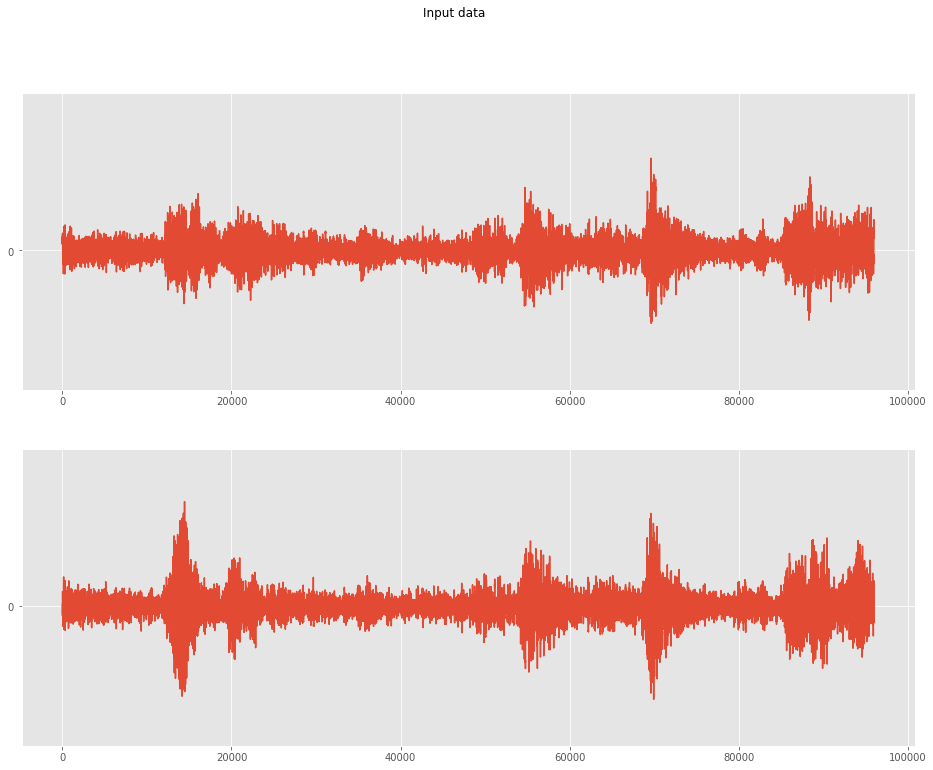

In [56]:
plt.figure(figsize=(16, 12))
for i in range(inputs.shape[0]):
    plt.subplot(inputs.shape[0], 1, i+1)
    plt.plot(inputs[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Input data")    
plt.plot()

In [57]:
label_voices = label_voice_signals[idx,:,:].cpu().detach().numpy()

In [58]:
plt.figure(figsize=(16, 12))
for i in range(label_voices.shape[0]):
    plt.subplot(label_voices.shape[0], 2, 2*i+1)
    plt.plot(label_voices[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
    plt.subplot(label_voices.shape[0], 2, 2*i+2)
    plt.plot(label_voices[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Ground Truth")    
plt.plot()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7b6563e488> (for post_execute):


KeyboardInterrupt: 

In [59]:
output_voice_signals = output_voices[idx,:,:].cpu().detach().numpy()
print(output_voice_signals.std())

0.053734347


In [ ]:
plt.figure(figsize=(16, 12))
for i in range(output_voice_signals.shape[0]):
    plt.subplot(output_voice_signals.shape[0], 2, 2*i+1)
    plt.plot(output_voice_signals[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
    plt.subplot(output_voice_signals.shape[0], 2, 2*i+2)
    plt.plot(output_voice_signals[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Output")
plt.plot()

In [60]:
ipd.Audio(data=(inputs[0]), rate=SAMPLE_RATE, normalize=False)

In [61]:
ipd.Audio(data=(label_voices[0]), rate=SAMPLE_RATE, normalize=False)

In [62]:
print(output_voice_signals.shape)

(2, 96000)


In [63]:
np.min(label_voices[0])

-0.52616316

In [64]:
ipd.Audio(data=output_voice_signals, rate=SAMPLE_RATE, normalize=False)

In [45]:
ipd.Audio(data=(output_bg_signals[0]), rate=22050, normalize=True)

NameError: name 'output_bg_signals' is not defined

In [ ]:
from librosa.core import stft, istft
from librosa.display import specshow

In [ ]:
y = output_voice_signals[0]

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
# D = np.clip(D, -20, 0)

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
Y = stft(y)
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
Y[:2, :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
Y[np.where(np.sum(np.abs(Y), axis=1) >= 10), :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
# Y = librosa.util.normalize(Y)

In [ ]:
plt.plot(istft(Y))

In [ ]:
D = librosa.amplitude_to_db(np.abs(Y), ref=1.0)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

In [ ]:
newy = istft(Y)

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(newy)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
y_gt = label_voices[0]
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_gt)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
x = data[0][1].cpu().numpy()

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
ipd.Audio(data=(labels[3]), rate=22050)

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
top = np.sum(librosa.util.normalize(outputs[0]) ** 2) / outputs[0].shape[0]
bottom = np.sum(librosa.util.normalize(labels[0]) ** 2) / labels[0].shape[0]

In [ ]:
SDR = 10 * np.log10(top / bottom)

In [ ]:
print(SDR)

In [ ]:
binaural = False
if outputs.shape[0] == 2:
    binaural = True

In [ ]:
import os
base_dir = 'jan24'
os.makedirs(base_dir, exist_ok=True)

In [ ]:
if not binaural:
    for i in range(outputs.shape[0]):
        librosa.output.write_wav('{}/input_{}.wav'.format(base_dir, i), inputs[i], sr=22050)
        librosa.output.write_wav('{}/output_{}.wav'.format(base_dir, i), 100 * outputs[i], sr=22050)
        librosa.output.write_wav('{}/label_{}.wav'.format(base_dir, i), labels[i], sr=22050)
else:
    librosa.output.write_wav('{}/input.wav'.format(base_dir, i), np.asfortranarray(np.vstack(inputs)), sr=22050)
    librosa.output.write_wav('{}/output.wav'.format(base_dir, i), np.asfortranarray(np.vstack(outputs)), sr=22050)
    librosa.output.write_wav('{}/label.wav'.format(base_dir, i), np.asfortranarray(np.vstack(labels)), sr=22050)
        

233 => 1.121
150 => 1.835
100 => 1.036
50 => 0.648